<a href="https://colab.research.google.com/github/Nathalia-Prada/proyecto-integrador-equipo25/blob/main/Avance5Equipo25/Avance5Equipo25_modelo_alterno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Avance 5. Modelo de prueba: Forecasting con XGBoost**
Objetivos:

- 3.5 Mejorar significativamente el rendimiento al aprovechar las fortalezas de diferentes modelos y reducir sus debilidades.

- 3.6 Evaluar la calidad de las predicciones del modelo en datos no vistos.


###**Equipo 25**


### Estudiantes


* A01793899 - Andrés Julián López Hurtado
* A01793999 - Nathalia Milena Prada Hernández
* A01794404 - Victor Alejandro Regueira Romero

Fecha: 27 de octubre de 2024

# Instrucciones

En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
- Incluir la optimización de hiperparámetros para los modelos más relevantes.
Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.


- Una vez que se han generado los modelos de ensamble, sintetizar los resultados en una tabla comparativa en la que se incluyan los modelos individuales de la fase previa.
Los modelos deben ser ordenados por la métrica principal, pero el resumen debe incorporar otras métricas pertinentes.
Se deberán incluir también los tiempos de entrenamiento.
Se elige el modelo final alineado con los objetivos y necesidades del negocio.


- Del modelo elegido, generar algunos gráficos significativos con su interpretación. La siguiente lista proporciona ejemplos, pero no es exhaustiva:
  1. Curva ROC
  2. Matriz de confusión
  3. Curva de Precisión-Recall
  4. Análisis de residuos
  5. Gráfico de importancia de características
  6. Tendencia y predicción (para series temporales)
  7. Diagrama de árbol (para árboles de decisión)

# Importar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Librerias

In [ ]:
import pandas as pd

# Data Cleaning and Preprocessing

## Importando CSV

In [ ]:
original_data = pd.read_csv('/content/drive/MyDrive/0-Actual/MNA/proyecto_integrador/clean_silver_consumption.csv')

In [ ]:
original_data.head()

In [ ]:
original_data.info()

## Cambiar fecha de objeto a fecha

In [ ]:
original_data['date'] = pd.to_datetime(original_data['date'], format='%Y-%m-%d')

print(original_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40375 entries, 0 to 40374
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   name                     40375 non-null  int64         
 1   date                     40375 non-null  datetime64[ns]
 2   total_distance_used_sum  40375 non-null  float64       
 3   total_fuel_used_sum      40375 non-null  float64       
 4   consumption              40375 non-null  float64       
 5   performance              40375 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.8 MB
None


In [ ]:
original_data['name'].value_counts()

name
738     61
602     61
1016    61
1182    61
1103    61
        ..
1348     1
1337     1
1276     1
1346     1
1340     1
Name: count, Length: 892, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


## Feature Engineering for Time-Series Data

In [ ]:
# Definir un umbral mínimo de registros por 'name'
min_records = 50  # Ajusta según tus necesidades

# Contar registros por 'name'
name_counts = original_data['name'].value_counts()

# Seleccionar nombres con al menos 'min_records' registros
selected_names = name_counts[name_counts >= min_records].index

# Filtrar el dataframe
filtered_data = original_data[original_data['name'].isin(selected_names)].copy()

print(f"Total de trucks seleccionados: {filtered_data['name'].nunique()}")


Total de trucks seleccionados: 565


In [ ]:
# Ordenar los datos
filtered_data.sort_values(by=['name', 'date'], inplace=True)

# Resetear el índice
filtered_data.reset_index(drop=True, inplace=True)


#Ingeniería de Características
Crear características como lag, medias móviles y transformaciones de Fourier.

- Crear Funciones de Ingeniería de Características

In [ ]:
def create_lag_features(df, target, lag_steps=3):
    for lag in range(1, lag_steps + 1):
        df[f'lag_{lag}'] = df.groupby('name')[target].shift(lag)
    return df

def create_rolling_mean(df, target, window_size=5):
    df['rolling_mean'] = df.groupby('name')[target].rolling(window=window_size).mean().reset_index(0, drop=True)
    return df

def apply_fourier_transform(df, target):
    # Aplicar FFT a cada grupo de 'name'
    df['fourier_transform'] = df.groupby('name')[target].transform(lambda x: np.abs(np.fft.fft(x)).mean())
    return df

def create_time_features(df):
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['week_of_year'] = df['date'].dt.isocalendar().week
    return df


In [ ]:
# Crear características de tiempo
filtered_data = create_time_features(filtered_data)

# Crear lag features
filtered_data = create_lag_features(filtered_data, 'consumption', lag_steps=3)

# Crear rolling mean
filtered_data = create_rolling_mean(filtered_data, 'consumption', window_size=5)

# Aplicar Fourier Transform
filtered_data = apply_fourier_transform(filtered_data, 'consumption')

# Eliminar filas con valores NaN generados por las lag features y rolling mean
filtered_data.dropna(inplace=True)

print(filtered_data.head())


   name       date  total_distance_used_sum  total_fuel_used_sum  consumption  \
4   337 2024-07-05               365.366148            24.303824     8.653096   
5   337 2024-07-06                 3.728226            12.944428     0.288018   
6   337 2024-07-07              1171.905706            68.420548     8.653096   
7   337 2024-07-08              1194.275062            66.571344     8.653096   
8   337 2024-07-09              1415.483138            99.592844    14.212699   

   performance  day_of_week  month  week_of_year     lag_1     lag_2  \
4     0.066519            4      7            27  3.484660  8.653096   
5     3.472007            5      7            27  8.653096  3.484660   
6     0.058384            6      7            27  0.288018  8.653096   
7     0.055742            0      7            28  8.653096  0.288018   
8     0.070360            1      7            28  8.653096  8.653096   

      lag_3  rolling_mean  fourier_transform  
4  8.653096      7.619409        

# Selección de Características y Preparación de Datos

In [ ]:
# Seleccionar características
feature_cols = [
    'lag_1', 'lag_2', 'lag_3',
    'rolling_mean',
    'fourier_transform',
    'day_of_week', 'month', 'week_of_year'
]

X = filtered_data[feature_cols + ['name']]
y = filtered_data['consumption']

print(f"Características seleccionadas: {X.columns.tolist()}")


Características seleccionadas: ['lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'fourier_transform', 'day_of_week', 'month', 'week_of_year', 'name']


# Codificación de Variables Categóricas
- Codificar la columna name utilizando Target Encoding o One-Hot Encoding. Dado el alto número de categorías, es más eficiente usar Target Encoding.

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import TargetEncoder

# Inicializar el encoder
encoder = TargetEncoder()

# Codificar 'name'
X['name_encoded'] = encoder.fit_transform(X['name'], y)

# Eliminar la columna original 'name'
X.drop('name', axis=1, inplace=True)

print(X.head())


      lag_1     lag_2     lag_3  rolling_mean  fourier_transform  day_of_week  \
4  3.484660  8.653096  8.653096      7.619409          25.651163            4   
5  8.653096  3.484660  8.653096      5.946393          25.651163            5   
6  0.288018  8.653096  3.484660      5.946393          25.651163            6   
7  8.653096  0.288018  8.653096      5.946393          25.651163            0   
8  8.653096  8.653096  0.288018      8.092001          25.651163            1   

   month  week_of_year  name_encoded  
4      7            27           337  
5      7            27           337  
6      7            27           337  
7      7            28           337  
8      7            28           337  


# Dividir los Datos en Conjuntos de Entrenamiento y Prueba
Mantener la orden temporal al dividir los datos.

In [ ]:
# Ordenar los datos por 'name' y 'date' nuevamente si es necesario
filtered_data.sort_values(by=['name', 'date'], inplace=True)

# Determinar el tamaño del conjunto de entrenamiento
train_size = int(len(filtered_data) * 0.8)

# Dividir los datos
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")


Datos de entrenamiento: (23645, 9)
Datos de prueba: (5912, 9)


# Crear un Pipeline para Preprocesamiento y Modelado
Usar un pipeline para encapsular el escalado y el modelo.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Definir el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
])


# Ajustar el Modelo y Realizar la Búsqueda de Hiperparámetros
Usar GridSearchCV con validación cruzada temporal.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Definir la distribución de los hiperparámetros
param_distributions = {
    'xgb__learning_rate': uniform(0.01, 0.19),  # Desde 0.01 hasta 0.2
    'xgb__max_depth': randint(3, 10),  # Entre 3 y 9
    'xgb__subsample': uniform(0.6, 0.4),  # Desde 0.6 hasta 1.0
    'xgb__colsample_bytree': uniform(0.6, 0.4),  # Desde 0.6 hasta 1.0
    'xgb__reg_alpha': uniform(0, 0.5),  # Desde 0 hasta 0.5
    'xgb__reg_lambda': uniform(1, 2),  # Desde 1 hasta 3
    'xgb__min_child_weight': randint(1, 6),  # Entre 1 y 5
    'xgb__gamma': uniform(0, 0.3),  # Desde 0 hasta 0.3
    'xgb__n_estimators': randint(100, 600),  # Entre 100 y 500
    # 'xgb__scale_pos_weight': [1, 2, 5]  # Descomenta si es relevante
}

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=100,  # Número de combinaciones a probar
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
random_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = random_search.best_params_
print("Mejores parámetros encontrados:")
print(best_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mejores parámetros encontrados:
{'xgb__colsample_bytree': 0.6783164539157186, 'xgb__gamma': 0.020808390262549634, 'xgb__learning_rate': 0.029147820261711067, 'xgb__max_depth': 4, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 598, 'xgb__reg_alpha': 0.30912694216894643, 'xgb__reg_lambda': 1.673108429777453, 'xgb__subsample': 0.8622890541522968}


# Entrenar el Modelo con los Mejores Parámetros del Random Search

In [ ]:
# Actualizar el pipeline con los mejores parámetros
pipeline.set_params(**{key: val for key, val in best_params.items()})

# Entrenar el modelo
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.6783164539157186, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.020808390262549634,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.029147820261711067, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=4, max_leaves=None,
                              min_child_weight=5, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=598, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

# Evaluar el Modelo en el Conjunto de Prueba

In [ ]:
# Realizar predicciones
predictions = pipeline.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 0.98
RMSE: 1.41
MAPE: 24.40%


## Ejemplo de Cross Validation

In [ ]:
# Importar las bibliotecas necesarias
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Supongamos que 'pw_clean' es tu DataFrame limpio y preprocesado con una columna de fecha 'date' y 'consumo'
# Asegúrate de que 'pw_clean' está ordenado temporalmente
pw_clean = filtered_data.sort_values('date').reset_index(drop=True)

# Definir el objeto TimeSeriesSplit
n_splits = 6  # Puedes ajustar el número de splits según tus necesidades
ts_cv = TimeSeriesSplit(n_splits=n_splits)

# Crear subplots: una fila por cada fold
fig = make_subplots(rows=n_splits, cols=1, shared_xaxes=True,
                    subplot_titles=[f'Fold {fold + 1}' for fold in range(n_splits)])

# Iterar sobre cada fold y agregar las trazas de entrenamiento y prueba
for fold, (train_idx, test_idx) in enumerate(ts_cv.split(pw_clean)):
    # Seleccionar los datos de entrenamiento y prueba
    train = pw_clean.iloc[train_idx]
    test = pw_clean.iloc[test_idx]

    # Agregar la serie de datos 'Training Set'
    fig.add_trace(go.Scatter(
        x=train['date'],
        y=train['consumption'],  # Reemplaza 'consumption' con 'kWh' si es necesario
        mode='lines',
        name='Training Set',
        line=dict(color='blue'),
        showlegend=(fold == 0)  # Mostrar leyenda solo en el primer subplot
    ), row=fold + 1, col=1)

    # Agregar la serie de datos 'Test Set'
    fig.add_trace(go.Scatter(
        x=test['date'],
        y=test['consumption'],
        mode='lines',
        name='Test Set',
        line=dict(color='orange'),
        showlegend=(fold == 0)  # Mostrar leyenda solo en el primer subplot
    ), row=fold + 1, col=1)

    # Añadir una línea vertical para separar entrenamiento y prueba
    separation_date = test['date'].min()
    fig.add_vline(x=separation_date, line=dict(color='black', dash='dash'), row=fold + 1, col=1)

# Actualizar el diseño general del gráfico
fig.update_layout(
    height=300 * n_splits,  # Ajustar la altura según el número de folds
    title_text='Proceso de Validación Cruzada - Train/Test Splits',
    showlegend=True,
    hovermode='x unified'
)

# Actualizar los ejes y etiquetas
fig.update_xaxes(title_text='Fecha', row=n_splits, col=1)
fig.update_yaxes(title_text='Consumo de Combustible', row=1, col=1)

# Mostrar el gráfico
fig.show()

# Guardar el gráfico como archivo HTML (opcional)
fig.write_html("cross_validation_splits.html")


# Optimización con optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Definir los hiperparámetros a optimizar
    params = {
        'xgb__learning_rate': trial.suggest_loguniform('xgb__learning_rate', 0.01, 0.2),
        'xgb__max_depth': trial.suggest_int('xgb__max_depth', 3, 10),
        'xgb__subsample': trial.suggest_uniform('xgb__subsample', 0.6, 1.0),
        'xgb__colsample_bytree': trial.suggest_uniform('xgb__colsample_bytree', 0.6, 1.0),
        'xgb__reg_alpha': trial.suggest_loguniform('xgb__reg_alpha', 1e-4, 0.5),
        'xgb__reg_lambda': trial.suggest_loguniform('xgb__reg_lambda', 1.0, 3.0),
        'xgb__min_child_weight': trial.suggest_int('xgb__min_child_weight', 1, 10),
        'xgb__gamma': trial.suggest_uniform('xgb__gamma', 0.0, 0.5),
        'xgb__n_estimators': trial.suggest_int('xgb__n_estimators', 100, 500)
    }

    # Actualizar el pipeline con los parámetros actuales
    pipeline.set_params(**params)

    # Evaluar el modelo usando validación cruzada
    score = cross_val_score(
        pipeline, X_train, y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    ).mean()

    return score

# Crear un estudio de Optuna
study = optuna.create_study(direction='maximize')

# Ejecutar la optimización
study.optimize(objective, n_trials=100, timeout=600)  # Ajusta n_trials y timeout según tus recursos

# Obtener los mejores parámetros
optuna_best_params = study.best_params
print("Mejores parámetros encontrados por Optuna:")
print(optuna_best_params)

# Actualizar el pipeline con los mejores parámetros
pipeline.set_params(**optuna_best_params)

# Entrenar el modelo con los mejores parámetros
pipeline.fit(X_train, y_train)

# Evaluar el modelo
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE después de Optuna: {mae:.2f}")


[I 2024-10-25 15:44:45,844] A new study created in memory with name: no-name-bd49ecce-a985-453d-9e33-96d264daf096
[I 2024-10-25 15:44:48,616] Trial 0 finished with value: -1.0730701170860109 and parameters: {'xgb__learning_rate': 0.07727701205129524, 'xgb__max_depth': 7, 'xgb__subsample': 0.8631218981282098, 'xgb__colsample_bytree': 0.9594349483507308, 'xgb__reg_alpha': 0.0021700375461639995, 'xgb__reg_lambda': 2.5185083673719584, 'xgb__min_child_weight': 5, 'xgb__gamma': 0.410483473364993, 'xgb__n_estimators': 364}. Best is trial 0 with value: -1.0730701170860109.
[I 2024-10-25 15:44:50,372] Trial 1 finished with value: -1.0146697656357249 and parameters: {'xgb__learning_rate': 0.015372656230560923, 'xgb__max_depth': 5, 'xgb__subsample': 0.9342984634967783, 'xgb__colsample_bytree': 0.8050960689397764, 'xgb__reg_alpha': 0.01599095589505842, 'xgb__reg_lambda': 2.5342934066562854, 'xgb__min_child_weight': 4, 'xgb__gamma': 0.2062799708368569, 'xgb__n_estimators': 446}. Best is trial 1 wit

Mejores parámetros encontrados por Optuna:
{'xgb__learning_rate': 0.04168722116102373, 'xgb__max_depth': 3, 'xgb__subsample': 0.6845125615404064, 'xgb__colsample_bytree': 0.8998248780550882, 'xgb__reg_alpha': 0.0006299663290104011, 'xgb__reg_lambda': 2.2890651271387723, 'xgb__min_child_weight': 10, 'xgb__gamma': 0.35926468888390944, 'xgb__n_estimators': 446}
MAE después de Optuna: 0.98


## Ventajas de Optuna:
- **Eficiencia:** Utiliza optimización bayesiana para explorar de manera más inteligente el espacio de hiperparámetros.
- **Flexibilidad:** Permite definir fácilmente espacios de búsqueda complejos.
- **Integración:** Se integra bien con scikit-learn y otros frameworks.

# Visualizar las Predicciones vs Valores Reales

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test.values, mode='lines', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(y=predictions, mode='lines', name='Predicción', line=dict(color='red')))

fig.update_layout(
    title='Actual vs Predicción de Consumo',
    xaxis_title='Tiempo',
    yaxis_title='Consumo'
)

fig.show()

In [ ]:
# Importar las bibliotecas necesarias
import plotly.graph_objects as go
import plotly.subplots as sp
import pandas as pd

# Supongamos que 'y_test' y 'predictions' están alineados y que 'filtered_data' contiene las fechas y nombres

# Extraer las fechas y nombres correspondientes al conjunto de prueba
test_dates = filtered_data['date'].iloc[:len(y_test)].reset_index(drop=True)
test_names = filtered_data['name'].iloc[:len(y_test)].reset_index(drop=True)

# Crear un DataFrame para facilitar la manipulación
comparison_df = pd.DataFrame({
    'date': test_dates,
    'name': test_names,
    'Actual': y_test.values,
    'Predicción': predictions
})

print(comparison_df.head())

# Seleccionar los 5 camiones
selected_names = comparison_df['name'].unique()[:5]
print(f"Camiones seleccionados: {selected_names}")

# Filtrar el DataFrame para incluir solo los camiones seleccionados
selected_df = comparison_df[comparison_df['name'].isin(selected_names)].copy()

print(selected_df.head())

# Crear subplots: 5 filas, 1 columna
fig = sp.make_subplots(rows=5, cols=1, shared_xaxes=True,
                       subplot_titles=[f'Camión {name}' for name in selected_names])

# Añadir trazas para cada camión
for i, name in enumerate(selected_names, start=1):
    df_truck = selected_df[selected_df['name'] == name]

    # Trazar los valores 'Actual'
    fig.add_trace(go.Scatter(
        x=df_truck['date'],
        y=df_truck['Actual'],
        mode='lines',
        name='Actual',
        line=dict(color='blue'),
        showlegend=(i == 1)  # Mostrar leyenda solo en el primer subplot
    ), row=i, col=1)

    # Trazar las predicciones 'Predicción'
    fig.add_trace(go.Scatter(
        x=df_truck['date'],
        y=df_truck['Predicción'],
        mode='lines',
        name='Predicción',
        line=dict(color='red'),
        showlegend=(i == 1)  # Mostrar leyenda solo en el primer subplot
    ), row=i, col=1)

# Actualizar el diseño general
fig.update_layout(
    height=300 * 5,  # Altura ajustada para 5 subplots
    title_text='Actual vs Predicción de Consumo de Combustible para 5 Camiones',
    showlegend=True,
    hovermode='x unified'
)

# Mostrar el gráfico
fig.show()

# Guardar el gráfico como archivo HTML (opcional)
fig.write_html("actual_vs_prediccion_consumo_5_camiones.html")


        date  name    Actual  Predicción
0 2024-07-05   337  8.346799    6.323508
1 2024-07-06   337  7.680900    8.479596
2 2024-07-07   337  0.235215    4.413564
3 2024-07-08   337  7.948630    8.044972
4 2024-07-09   337  7.338305    7.816506
Camiones seleccionados: [337 346 353 388 389]
        date  name    Actual  Predicción
0 2024-07-05   337  8.346799    6.323508
1 2024-07-06   337  7.680900    8.479596
2 2024-07-07   337  0.235215    4.413564
3 2024-07-08   337  7.948630    8.044972
4 2024-07-09   337  7.338305    7.816506


# Predecir las Próximas 4 Semanas
Para realizar predicciones futuras, es necesario generar las características para las próximas 4 semanas basadas en las últimas observaciones.

Definir el Horizonte de Predicción

In [ ]:
# Definir el número de semanas a predecir
weeks_ahead = 4
periods = weeks_ahead * 7  # Suponiendo datos diarios

# Seleccionar un 'name' específico para la predicción
selected_name = selected_names[4]  # Cambia según sea necesario


In [ ]:
# Obtener la última fecha de los datos
last_date = filtered_data['date'].max()

# Crear un dataframe para las fechas futuras
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')

# Crear un dataframe vacío para las predicciones
future_df = pd.DataFrame({'date': future_dates})



future_df['name'] = selected_name

# Ordenar por 'name' y 'date'
future_df.sort_values(by=['name', 'date'], inplace=True)

# Crear características de tiempo
future_df = create_time_features(future_df)


In [ ]:
# Obtener los últimos 3 valores de 'consumption' del conjunto de datos filtrados para el 'name' seleccionado
last_consumptions = filtered_data[filtered_data['name'] == selected_name]['consumption'].tail(3).values

# Verificar que hay suficientes valores
if len(last_consumptions) < 3:
    raise ValueError("No hay suficientes valores de 'consumption' para generar las lag features.")

# Asignar los lag features a las primeras filas de future_df
for i in range(1, 4):
    if i <= len(last_consumptions):
        future_df.at[0, f'lag_{i}'] = last_consumptions[-i]
    else:
        # Manejar de otra manera si no hay suficientes lags
        future_df.at[0, f'lag_{i}'] = np.nan

# Crear rolling mean basada en los últimos valores conocidos
rolling_window_size = 5
last_rolling_mean = filtered_data[filtered_data['name'] == selected_name]['consumption'].tail(rolling_window_size).mean()
future_df.at[0, 'rolling_mean'] = last_rolling_mean

# Aplicar Fourier Transform basada en los datos históricos
# Aquí, como simplificación, utilizamos la media del Fourier transformada de los datos históricos
historical_fourier_mean = filtered_data[filtered_data['name'] == selected_name]['fourier_transform'].mean()
future_df['fourier_transform'] = historical_fourier_mean


In [ ]:
# Inicializar una lista para almacenar las predicciones
predictions = []

# Copia de future_df para manipular
future_df_iter = future_df.copy()

for i in range(len(future_df_iter)):
    # Seleccionar la fila actual
    current_row = future_df_iter.iloc[i]

    # Si no es la primera fila, actualizar las lag features
    if i > 0:
        # Actualizar los lag features con las predicciones anteriores
        future_df_iter.at[i, 'lag_1'] = predictions[i-1]
        if i > 1:
            future_df_iter.at[i, 'lag_2'] = predictions[i-2]
        else:
            future_df_iter.at[i, 'lag_2'] = last_consumptions[-2]
        if i > 2:
            future_df_iter.at[i, 'lag_3'] = predictions[i-3]
        else:
            future_df_iter.at[i, 'lag_3'] = last_consumptions[-3]

        # Actualizar rolling mean
        window_values = predictions[max(0, i-rolling_window_size):i]
        if len(window_values) > 0:
            future_df_iter.at[i, 'rolling_mean'] = np.mean(window_values)
        else:
            future_df_iter.at[i, 'rolling_mean'] = last_rolling_mean

    # Fourier transform ya está asignada como la media histórica

    # Seleccionar las características necesarias
    future_X = future_df_iter.iloc[i][feature_cols]
    future_X['name_encoded'] = encoder.transform([future_df_iter.iloc[i]['name']])[0]

    # Escalar las características
    future_X_scaled = pipeline.named_steps['scaler'].transform([future_X])

    # Realizar la predicción
    pred = pipeline.named_steps['xgb'].predict(future_X_scaled)[0]

    # Almacenar la predicción
    predictions.append(pred)

    # Asignar la predicción al DataFrame
    future_df_iter.at[i, 'predicted_consumption'] = pred

print(future_df_iter[['date', 'predicted_consumption']].head(14))


         date  predicted_consumption
0  2024-09-01               7.828179
1  2024-09-02               6.693500
2  2024-09-03               6.628538
3  2024-09-04               7.022221
4  2024-09-05               7.351423
5  2024-09-06               7.243907
6  2024-09-07               6.692021
7  2024-09-08               6.842820
8  2024-09-09               7.038618
9  2024-09-10               7.326376
10 2024-09-11               6.941061
11 2024-09-12               6.866525
12 2024-09-13               6.919224
13 2024-09-14               7.033247


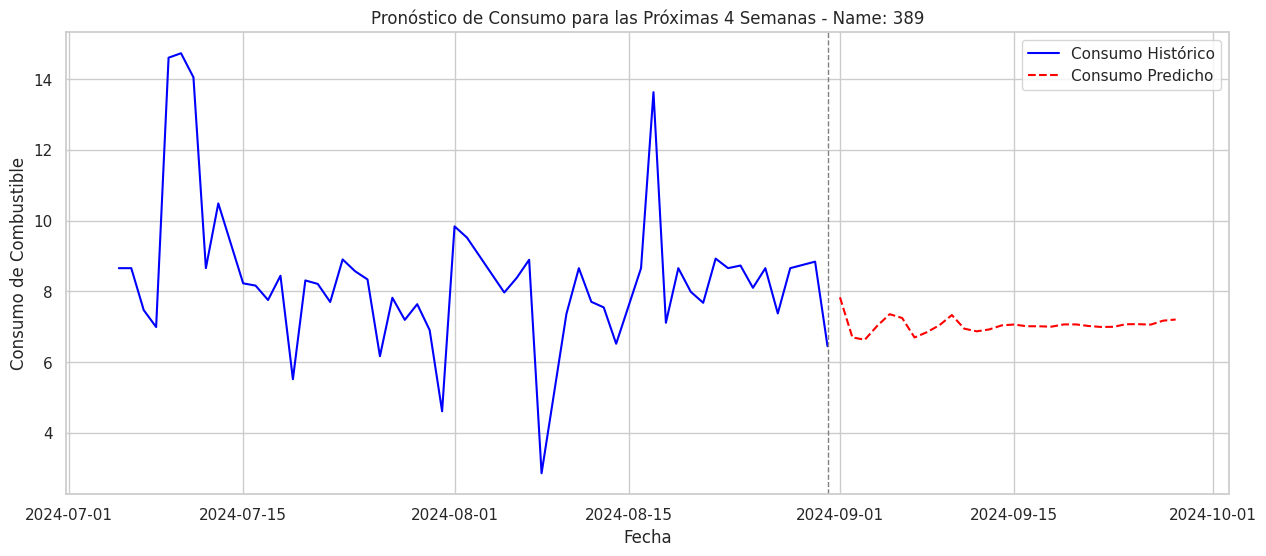

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')


# Filtrar los datos históricos y las predicciones futuras
historical_data = filtered_data[filtered_data['name'] == selected_name]
future_predictions_selected = future_df_iter[future_df_iter['name'] == selected_name]

# Crear el gráfico
plt.figure(figsize=(15, 6))

# Plot de los datos históricos
plt.plot(historical_data['date'], historical_data['consumption'], label='Consumo Histórico', color='blue')

# Plot de las predicciones futuras
plt.plot(future_predictions_selected['date'], future_predictions_selected['predicted_consumption'],
         label='Consumo Predicho', color='red', linestyle='--')

# Añadir una línea vertical para separar los datos históricos de las predicciones
plt.axvline(x=historical_data['date'].max(), color='gray', linestyle='--', linewidth=1)

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Consumo de Combustible')
plt.title(f'Pronóstico de Consumo para las Próximas 4 Semanas - Name: {selected_name}')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
plt.savefig('pronostico_consumo_5_camiones.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## Conclusión

Este enfoque te permitirá visualizar claramente cómo se divide tu conjunto de datos en diferentes folds durante el proceso de validación cruzada. La utilización de Plotly proporciona una visualización interactiva que facilita la exploración y comprensión de las divisiones de entrenamiento y prueba en cada fold.


Al ejecutar el código anterior, obtendrás una figura con 4 subplots, cada uno representando un fold de la validación cruzada. Cada subplot mostrará:

- Línea Azul: Datos de entrenamiento.
- Línea Naranja: Datos de prueba.
- Línea Negra Discontinua: Separación entre entrenamiento y prueba.